In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [2]:
import numpy as np
import torch
import CNN
import tqdm
import random
device = torch.device('cuda')

In [3]:
def cvt_data_loader(x,y=None,batch_size= 32,shuffle = True):
    if y is None:
        return torch.utils.data.DataLoader(torch.tensor(x,dtype = torch.float32),batch_size= batch_size,shuffle=shuffle)
    
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(x,dtype = torch.float32),
                              torch.tensor(y,dtype = torch.float32))
                              ,batch_size= batch_size,shuffle=shuffle)
def cvt_one_hot(y,num_classes):
    one_hot = np.zeros((len(y),num_classes))
    one_hot[np.arange(len(y)),y] = 1
    return one_hot

In [4]:
train_dl_lis = []
for i in range(20):
    data = np.load(f'cifar-10-augmented{i}.npz')
    x_train, y_train,  = np.array(data['x_train_aug'],dtype = np.float32)/ 255, data['y_train_aug']
    x_train = x_train.transpose(0,3,1,2)
    y_train = cvt_one_hot(y_train,10)
    batch_szie = 125
    train_dl = cvt_data_loader(x_train, y_train, batch_szie, True)
    train_dl_lis.append(train_dl)
x_test, y_test =  np.array(data['x_test'],dtype = np.float32)/255, data['y_test']
x_test = x_test.transpose(0,3,1,2)
y_test = cvt_one_hot(y_test,10)
test_dl = cvt_data_loader(x_test, y_test, batch_szie, True)

In [5]:
model = CNN.MyResCNN()

In [6]:
epochs = 200
critarion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr =  5e-2, momentum=0.9, weight_decay=5e-4)
seheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs,eta_min= 5e-6)

In [ ]:
model = model.to(device)
model = model.train()
train_loss = []
test_loss = []
train_accu = []
test_accu = []
max_accu = 0
min_loss = 1000
tf = True
for epoch in range(1, epochs + 1):
    print(f"Epoch : {epoch}")
    sum_loss = 0
    sum_accu = 0
    model = model.train()
    ind = random.randint(0,len(train_dl_lis) - 1)
    print(f"Using Training Data {ind}")
    train_dl=train_dl_lis[ind]
    for x, y in tqdm.tqdm(train_dl):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        out = model.forward(x)
        loss = critarion(out, y)
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(),torch.tensor(1))
        optimizer.step()
        sum_loss += float(loss) * len(x)
        sum_accu += float(torch.sum(torch.argmax(out,dim = 1)==torch.argmax(y,dim=1)))
    optimizer.zero_grad()
    seheduler.step()
    torch.cuda.empty_cache()
    sum_loss = sum_loss/ len(train_dl.dataset)
    sum_accu = sum_accu / len(train_dl.dataset)
    print(f"Train Accuracy : {sum_accu}")
    print(f"Train Loss : {sum_loss}")
    train_loss.append(sum_loss)
    train_accu.append(sum_accu)
    sum_loss = 0
    sum_accu = 0
    model = model.eval()
    for x, y in tqdm.tqdm(test_dl):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        out = model.forward(x)
        loss = critarion(out, y)
        sum_loss += float(loss) * len(x)
        sum_accu += float(torch.sum(torch.argmax(out,dim = 1)==torch.argmax(y,dim=1)))
    torch.cuda.empty_cache()
    sum_loss = sum_loss/ len(test_dl.dataset)
    sum_accu = sum_accu / len(test_dl.dataset)
    if sum_accu > max_accu:
        max_accu = sum_accu
        torch.save({'state_dict' : model.state_dict(), 'cfgDict' : model.cfgDict},"CNN_accu")
    if sum_loss < min_loss:
        min_loss = sum_loss
        torch.save({'state_dict' : model.state_dict(), 'cfgDict' : model.cfgDict},"CNN_loss")
    print(f"Val Accuracy : {sum_accu}")
    print(f"Val Loss : {sum_loss}")
    test_accu.append(sum_accu)
    test_loss.append(sum_loss)
    # if ((epoch > 2) and (((test_loss[-1] > (test_loss[-2])) and tf) 
    #                      or (train_loss[-1] < (test_loss[-1] - 0.15)) 
    #                      or ((train_accu[-1] > (test_accu[-1] + 0.025)) and tf))):
    #     print("Intersting Saved at epoch: {}".format(epoch))
    #     torch.save({'state_dict' : model.state_dict(), 'cfgDict' : model.cfgDict},f"Pre_VIT{epoch}")
    #     tf = False

Epoch : 1
Using Training Data 15


100%|██████████| 400/400 [00:11<00:00, 35.24it/s]


Train Accuracy : 0.3099
Train Loss : 1.8406971380114556


100%|██████████| 80/80 [00:00<00:00, 148.85it/s]


Val Accuracy : 0.3335
Val Loss : 1.9459324076771736
Epoch : 2
Using Training Data 15


100%|██████████| 400/400 [00:10<00:00, 36.94it/s]


Train Accuracy : 0.46654
Train Loss : 1.468968806862831


100%|██████████| 80/80 [00:00<00:00, 148.96it/s]


Val Accuracy : 0.5053
Val Loss : 1.40355082154274
Epoch : 3
Using Training Data 2


100%|██████████| 400/400 [00:10<00:00, 37.06it/s]


Train Accuracy : 0.5489
Train Loss : 1.2528036512434482


100%|██████████| 80/80 [00:00<00:00, 148.94it/s]


Val Accuracy : 0.6321
Val Loss : 1.0455007553100586
Epoch : 4
Using Training Data 15


100%|██████████| 400/400 [00:10<00:00, 37.13it/s]


Train Accuracy : 0.6175
Train Loss : 1.0711490470170975


100%|██████████| 80/80 [00:00<00:00, 145.14it/s]


Val Accuracy : 0.656
Val Loss : 0.9934395417571068
Epoch : 5
Using Training Data 3


100%|██████████| 400/400 [00:10<00:00, 37.03it/s]


Train Accuracy : 0.65364
Train Loss : 0.9719053551554679


100%|██████████| 80/80 [00:00<00:00, 149.17it/s]


Val Accuracy : 0.6791
Val Loss : 0.9163153626024723
Epoch : 6
Using Training Data 6


100%|██████████| 400/400 [00:10<00:00, 37.05it/s]


Train Accuracy : 0.68028
Train Loss : 0.9024620667099953


100%|██████████| 80/80 [00:00<00:00, 148.62it/s]


Val Accuracy : 0.697
Val Loss : 0.8749024584889412
Epoch : 7
Using Training Data 12


100%|██████████| 400/400 [00:10<00:00, 36.88it/s]


Train Accuracy : 0.70438
Train Loss : 0.8338229361176491


100%|██████████| 80/80 [00:00<00:00, 149.44it/s]


Val Accuracy : 0.7445
Val Loss : 0.7408005133271217
Epoch : 8
Using Training Data 8


100%|██████████| 400/400 [00:10<00:00, 36.87it/s]


Train Accuracy : 0.72004
Train Loss : 0.7945520333945751


100%|██████████| 80/80 [00:00<00:00, 149.18it/s]


Val Accuracy : 0.6976
Val Loss : 0.8682559303939342
Epoch : 9
Using Training Data 0


100%|██████████| 400/400 [00:10<00:00, 36.99it/s]


Train Accuracy : 0.73352
Train Loss : 0.754503753632307


100%|██████████| 80/80 [00:00<00:00, 145.39it/s]


Val Accuracy : 0.7672
Val Loss : 0.6805561020970344
Epoch : 10
Using Training Data 4


100%|██████████| 400/400 [00:11<00:00, 35.75it/s]


Train Accuracy : 0.746
Train Loss : 0.7194488625228405


100%|██████████| 80/80 [00:00<00:00, 144.31it/s]


Val Accuracy : 0.7814
Val Loss : 0.6331871386617423
Epoch : 11
Using Training Data 15


100%|██████████| 400/400 [00:11<00:00, 35.32it/s]


Train Accuracy : 0.76024
Train Loss : 0.6875516890734434


100%|██████████| 80/80 [00:00<00:00, 144.70it/s]


Val Accuracy : 0.7767
Val Loss : 0.6508788798004389
Epoch : 12
Using Training Data 12


100%|██████████| 400/400 [00:11<00:00, 35.91it/s]


Train Accuracy : 0.76956
Train Loss : 0.6553486298024654


100%|██████████| 80/80 [00:00<00:00, 148.67it/s]


Val Accuracy : 0.7775
Val Loss : 0.6551678247749806
Epoch : 13
Using Training Data 8


100%|██████████| 400/400 [00:10<00:00, 36.94it/s]


Train Accuracy : 0.77864
Train Loss : 0.6298817945271731


100%|██████████| 80/80 [00:00<00:00, 149.02it/s]


Val Accuracy : 0.7642
Val Loss : 0.6712696094065904
Epoch : 14
Using Training Data 0


100%|██████████| 400/400 [00:10<00:00, 36.68it/s]


Train Accuracy : 0.7848
Train Loss : 0.6132235829532147


100%|██████████| 80/80 [00:00<00:00, 148.89it/s]


Val Accuracy : 0.7817
Val Loss : 0.6353518426418304
Epoch : 15
Using Training Data 15


100%|██████████| 400/400 [00:10<00:00, 36.86it/s]


Train Accuracy : 0.79368
Train Loss : 0.5836482419818639


100%|██████████| 80/80 [00:00<00:00, 149.01it/s]


Val Accuracy : 0.7813
Val Loss : 0.6567886978387832
Epoch : 16
Using Training Data 0


100%|██████████| 400/400 [00:10<00:00, 36.87it/s]


Train Accuracy : 0.814
Train Loss : 0.5282296404242516


100%|██████████| 80/80 [00:00<00:00, 149.45it/s]


Val Accuracy : 0.8102
Val Loss : 0.5656666714698076
Epoch : 17
Using Training Data 19


100%|██████████| 400/400 [00:10<00:00, 36.86it/s]


Train Accuracy : 0.78814
Train Loss : 0.6072814459353686


100%|██████████| 80/80 [00:00<00:00, 148.39it/s]


Val Accuracy : 0.789
Val Loss : 0.6008685916662216
Epoch : 18
Using Training Data 1


100%|██████████| 400/400 [00:10<00:00, 36.88it/s]


Train Accuracy : 0.7941
Train Loss : 0.5887716659903526


100%|██████████| 80/80 [00:00<00:00, 149.17it/s]


Val Accuracy : 0.8081
Val Loss : 0.575178861990571
Epoch : 19
Using Training Data 17


100%|██████████| 400/400 [00:10<00:00, 36.89it/s]


Train Accuracy : 0.8
Train Loss : 0.573628433868289


100%|██████████| 80/80 [00:00<00:00, 149.03it/s]


Val Accuracy : 0.8038
Val Loss : 0.585928100720048
Epoch : 20
Using Training Data 0


100%|██████████| 400/400 [00:10<00:00, 37.01it/s]


Train Accuracy : 0.82966
Train Loss : 0.4825216971337795


100%|██████████| 80/80 [00:00<00:00, 147.76it/s]


Val Accuracy : 0.81
Val Loss : 0.5594508238136768
Epoch : 21
Using Training Data 16


100%|██████████| 400/400 [00:10<00:00, 37.12it/s]


Train Accuracy : 0.80254
Train Loss : 0.5625069889426232


100%|██████████| 80/80 [00:00<00:00, 148.93it/s]


Val Accuracy : 0.825
Val Loss : 0.5178135875612497
Epoch : 22
Using Training Data 1


100%|██████████| 400/400 [00:10<00:00, 37.13it/s]


Train Accuracy : 0.82338
Train Loss : 0.5041868137568235


100%|██████████| 80/80 [00:00<00:00, 148.83it/s]


Val Accuracy : 0.8081
Val Loss : 0.5615028657019139
Epoch : 23
Using Training Data 9


100%|██████████| 400/400 [00:10<00:00, 37.16it/s]


Train Accuracy : 0.80994
Train Loss : 0.5420841685682535


100%|██████████| 80/80 [00:00<00:00, 148.75it/s]


Val Accuracy : 0.806
Val Loss : 0.56449412740767
Epoch : 24
Using Training Data 4


100%|██████████| 400/400 [00:10<00:00, 37.15it/s]


Train Accuracy : 0.81634
Train Loss : 0.5282013772428036


100%|██████████| 80/80 [00:00<00:00, 148.72it/s]


Val Accuracy : 0.7916
Val Loss : 0.617880092188716
Epoch : 25
Using Training Data 10


100%|██████████| 400/400 [00:10<00:00, 37.11it/s]


Train Accuracy : 0.82262
Train Loss : 0.5052325143665075


100%|██████████| 80/80 [00:00<00:00, 147.52it/s]


Val Accuracy : 0.7913
Val Loss : 0.6618447970598936
Epoch : 26
Using Training Data 8


100%|██████████| 400/400 [00:10<00:00, 37.02it/s]


Train Accuracy : 0.82536
Train Loss : 0.5016434206813574


100%|██████████| 80/80 [00:00<00:00, 148.86it/s]


Val Accuracy : 0.8309
Val Loss : 0.5040663208812475
Epoch : 27
Using Training Data 14


100%|██████████| 400/400 [00:11<00:00, 35.96it/s]


Train Accuracy : 0.82162
Train Loss : 0.509726959913969


100%|██████████| 80/80 [00:00<00:00, 147.26it/s]


Val Accuracy : 0.7832
Val Loss : 0.6606178265064955
Epoch : 28
Using Training Data 13


100%|██████████| 400/400 [00:10<00:00, 37.09it/s]


Train Accuracy : 0.82576
Train Loss : 0.5035403011739255


100%|██████████| 80/80 [00:00<00:00, 149.01it/s]


Val Accuracy : 0.8059
Val Loss : 0.5673722464591264
Epoch : 29
Using Training Data 14


100%|██████████| 400/400 [00:10<00:00, 36.85it/s]


Train Accuracy : 0.85398
Train Loss : 0.4122697748243809


100%|██████████| 80/80 [00:00<00:00, 148.82it/s]


Val Accuracy : 0.7992
Val Loss : 0.610154316201806
Epoch : 30
Using Training Data 1


100%|██████████| 400/400 [00:11<00:00, 35.57it/s]


Train Accuracy : 0.83564
Train Loss : 0.469804880656302


100%|██████████| 80/80 [00:00<00:00, 141.22it/s]


Val Accuracy : 0.7985
Val Loss : 0.5873492777347564
Epoch : 31
Using Training Data 5


100%|██████████| 400/400 [00:11<00:00, 35.12it/s]


Train Accuracy : 0.82726
Train Loss : 0.49543369621038436


100%|██████████| 80/80 [00:00<00:00, 138.76it/s]


Val Accuracy : 0.8223
Val Loss : 0.5210359789431095
Epoch : 32
Using Training Data 10


100%|██████████| 400/400 [00:11<00:00, 34.55it/s]


Train Accuracy : 0.8435
Train Loss : 0.44843625873327253


100%|██████████| 80/80 [00:00<00:00, 113.84it/s]


Val Accuracy : 0.8242
Val Loss : 0.5133179135620594
Epoch : 33
Using Training Data 5


100%|██████████| 400/400 [00:11<00:00, 35.41it/s]


Train Accuracy : 0.86216
Train Loss : 0.3936143541708589


100%|██████████| 80/80 [00:00<00:00, 148.62it/s]


Val Accuracy : 0.8124
Val Loss : 0.5884871207177639
Epoch : 34
Using Training Data 17


100%|██████████| 400/400 [00:10<00:00, 36.81it/s]


Train Accuracy : 0.83374
Train Loss : 0.47732227452099324


100%|██████████| 80/80 [00:00<00:00, 148.51it/s]


Val Accuracy : 0.8153
Val Loss : 0.53880046159029
Epoch : 35
Using Training Data 2


100%|██████████| 400/400 [00:10<00:00, 36.76it/s]


Train Accuracy : 0.83228
Train Loss : 0.4767355040460825


100%|██████████| 80/80 [00:00<00:00, 148.86it/s]


Val Accuracy : 0.7958
Val Loss : 0.6090040348470211
Epoch : 36
Using Training Data 2


100%|██████████| 400/400 [00:10<00:00, 37.01it/s]


Train Accuracy : 0.88296
Train Loss : 0.3373989702016115


100%|██████████| 80/80 [00:00<00:00, 147.97it/s]


Val Accuracy : 0.8169
Val Loss : 0.5666095048189164
Epoch : 37
Using Training Data 9


100%|██████████| 400/400 [00:10<00:00, 36.97it/s]


Train Accuracy : 0.83736
Train Loss : 0.4694248892366886


100%|██████████| 80/80 [00:00<00:00, 148.69it/s]


Val Accuracy : 0.8147
Val Loss : 0.545821899920702
Epoch : 38
Using Training Data 14


100%|██████████| 400/400 [00:10<00:00, 36.84it/s]


Train Accuracy : 0.8507
Train Loss : 0.4268553379923105


100%|██████████| 80/80 [00:00<00:00, 149.05it/s]


Val Accuracy : 0.8206
Val Loss : 0.5589204907417298
Epoch : 39
Using Training Data 18


100%|██████████| 400/400 [00:10<00:00, 36.91it/s]


Train Accuracy : 0.83806
Train Loss : 0.4648593218624592


100%|██████████| 80/80 [00:00<00:00, 148.92it/s]


Val Accuracy : 0.8205
Val Loss : 0.5442789766937495
Epoch : 40
Using Training Data 4


100%|██████████| 400/400 [00:10<00:00, 36.83it/s]


Train Accuracy : 0.8473
Train Loss : 0.44068606734275817


100%|██████████| 80/80 [00:00<00:00, 148.76it/s]


Val Accuracy : 0.822
Val Loss : 0.5561151549220085
Epoch : 41
Using Training Data 0


100%|██████████| 400/400 [00:10<00:00, 36.86it/s]


Train Accuracy : 0.847
Train Loss : 0.43642431251704694


100%|██████████| 80/80 [00:00<00:00, 148.68it/s]


Val Accuracy : 0.7731
Val Loss : 0.6963906724005937
Epoch : 42
Using Training Data 1


100%|██████████| 400/400 [00:10<00:00, 36.82it/s]


Train Accuracy : 0.85228
Train Loss : 0.4219917828217149


100%|██████████| 80/80 [00:00<00:00, 149.03it/s]


Val Accuracy : 0.8361
Val Loss : 0.4924642346799374
Epoch : 43
Using Training Data 17


100%|██████████| 400/400 [00:10<00:00, 36.83it/s]


Train Accuracy : 0.8547
Train Loss : 0.41734519336372616


100%|██████████| 80/80 [00:00<00:00, 148.75it/s]


Val Accuracy : 0.8276
Val Loss : 0.5083665985614061
Epoch : 44
Using Training Data 11


100%|██████████| 400/400 [00:10<00:00, 36.96it/s]


Train Accuracy : 0.84724
Train Loss : 0.4389114944264293


100%|██████████| 80/80 [00:00<00:00, 148.06it/s]


Val Accuracy : 0.8178
Val Loss : 0.5367049764841795
Epoch : 45
Using Training Data 19


100%|██████████| 400/400 [00:11<00:00, 35.84it/s]


Train Accuracy : 0.85566
Train Loss : 0.413635918200016


100%|██████████| 80/80 [00:00<00:00, 142.55it/s]


Val Accuracy : 0.839
Val Loss : 0.4863991141319275
Epoch : 46
Using Training Data 9


100%|██████████| 400/400 [00:11<00:00, 35.88it/s]


Train Accuracy : 0.8614
Train Loss : 0.4009594739601016


100%|██████████| 80/80 [00:00<00:00, 141.66it/s]


Val Accuracy : 0.8407
Val Loss : 0.4929157331585884
Epoch : 47
Using Training Data 15


100%|██████████| 400/400 [00:11<00:00, 35.72it/s]


Train Accuracy : 0.852
Train Loss : 0.4268061496317387


100%|██████████| 80/80 [00:00<00:00, 137.81it/s]


Val Accuracy : 0.8459
Val Loss : 0.4735885374248028
Epoch : 48
Using Training Data 18


100%|██████████| 400/400 [00:11<00:00, 35.99it/s]


Train Accuracy : 0.85924
Train Loss : 0.4035063860937953


100%|██████████| 80/80 [00:00<00:00, 142.07it/s]


Val Accuracy : 0.8319
Val Loss : 0.5045277666300535
Epoch : 49
Using Training Data 1


100%|██████████| 400/400 [00:11<00:00, 36.14it/s]


Train Accuracy : 0.8678
Train Loss : 0.3753750320151448


100%|██████████| 80/80 [00:00<00:00, 139.44it/s]


Val Accuracy : 0.8414
Val Loss : 0.4744154721498489
Epoch : 50
Using Training Data 14


100%|██████████| 400/400 [00:11<00:00, 35.92it/s]


Train Accuracy : 0.86418
Train Loss : 0.39069584604352714


100%|██████████| 80/80 [00:00<00:00, 137.75it/s]


Val Accuracy : 0.8201
Val Loss : 0.5576112490147352
Epoch : 51
Using Training Data 10


100%|██████████| 400/400 [00:11<00:00, 36.11it/s]


Train Accuracy : 0.8732
Train Loss : 0.3620600625127554


100%|██████████| 80/80 [00:00<00:00, 147.63it/s]


Val Accuracy : 0.8236
Val Loss : 0.5395156245678663
Epoch : 52
Using Training Data 17


100%|██████████| 400/400 [00:10<00:00, 36.79it/s]


Train Accuracy : 0.86688
Train Loss : 0.3779477395117283


100%|██████████| 80/80 [00:00<00:00, 148.59it/s]


Val Accuracy : 0.8003
Val Loss : 0.625813776254654
Epoch : 53
Using Training Data 16


100%|██████████| 400/400 [00:10<00:00, 36.65it/s]


Train Accuracy : 0.8561
Train Loss : 0.411756542660296


100%|██████████| 80/80 [00:00<00:00, 144.74it/s]


Val Accuracy : 0.8411
Val Loss : 0.48387990072369574
Epoch : 54
Using Training Data 14


100%|██████████| 400/400 [00:11<00:00, 36.35it/s]


Train Accuracy : 0.88404
Train Loss : 0.3319157722964883


100%|██████████| 80/80 [00:00<00:00, 145.11it/s]


Val Accuracy : 0.8358
Val Loss : 0.48708838447928426
Epoch : 55
Using Training Data 14


100%|██████████| 400/400 [00:11<00:00, 34.69it/s]


Train Accuracy : 0.9236
Train Loss : 0.21839688559994103


100%|██████████| 80/80 [00:00<00:00, 146.28it/s]


Val Accuracy : 0.8278
Val Loss : 0.5668227467685938
Epoch : 56
Using Training Data 12


100%|██████████| 400/400 [00:11<00:00, 34.58it/s]


Train Accuracy : 0.84984
Train Loss : 0.4297718819975853


100%|██████████| 80/80 [00:00<00:00, 146.32it/s]


Val Accuracy : 0.8086
Val Loss : 0.5643486745655537
Epoch : 57
Using Training Data 2


100%|██████████| 400/400 [00:11<00:00, 36.12it/s]


Train Accuracy : 0.85908
Train Loss : 0.39920739077031614


100%|██████████| 80/80 [00:00<00:00, 148.78it/s]


Val Accuracy : 0.8492
Val Loss : 0.46154674477875235
Epoch : 58
Using Training Data 14


100%|██████████| 400/400 [00:11<00:00, 36.18it/s]


Train Accuracy : 0.91572
Train Loss : 0.24174536583945155


100%|██████████| 80/80 [00:00<00:00, 146.40it/s]


Val Accuracy : 0.8415
Val Loss : 0.5114945974200964
Epoch : 59
Using Training Data 14


100%|██████████| 400/400 [00:11<00:00, 35.28it/s]


Train Accuracy : 0.94736
Train Loss : 0.1515369858685881


100%|██████████| 80/80 [00:00<00:00, 145.28it/s]


Val Accuracy : 0.7964
Val Loss : 0.6879625156521797
Epoch : 60
Using Training Data 17


100%|██████████| 400/400 [00:11<00:00, 36.15it/s]


Train Accuracy : 0.86758
Train Loss : 0.3825480616092682


100%|██████████| 80/80 [00:00<00:00, 140.56it/s]


Val Accuracy : 0.835
Val Loss : 0.5053673449903726
Epoch : 61
Using Training Data 14


100%|██████████| 400/400 [00:10<00:00, 36.52it/s]


Train Accuracy : 0.94158
Train Loss : 0.1697141478676349


100%|██████████| 80/80 [00:00<00:00, 141.97it/s]


Val Accuracy : 0.8229
Val Loss : 0.626297528296709
Epoch : 62
Using Training Data 6


100%|██████████| 400/400 [00:11<00:00, 36.22it/s]


Train Accuracy : 0.849
Train Loss : 0.43305889431387184


100%|██████████| 80/80 [00:00<00:00, 141.32it/s]


Val Accuracy : 0.8289
Val Loss : 0.5344981726258993
Epoch : 63
Using Training Data 15


100%|██████████| 400/400 [00:10<00:00, 36.40it/s]


Train Accuracy : 0.86466
Train Loss : 0.39120583564043043


100%|██████████| 80/80 [00:00<00:00, 139.97it/s]


Val Accuracy : 0.8503
Val Loss : 0.4529300816357136
Epoch : 64
Using Training Data 0


100%|██████████| 400/400 [00:11<00:00, 36.21it/s]


Train Accuracy : 0.86642
Train Loss : 0.3821564280614257


100%|██████████| 80/80 [00:00<00:00, 140.59it/s]


Val Accuracy : 0.8151
Val Loss : 0.566424410417676
Epoch : 65
Using Training Data 3


100%|██████████| 400/400 [00:11<00:00, 36.23it/s]


Train Accuracy : 0.86508
Train Loss : 0.38734612066298724


100%|██████████| 80/80 [00:00<00:00, 140.95it/s]


Val Accuracy : 0.8273
Val Loss : 0.5080998677760362
Epoch : 66
Using Training Data 10


100%|██████████| 400/400 [00:10<00:00, 36.43it/s]


Train Accuracy : 0.87768
Train Loss : 0.3478311202675104


100%|██████████| 80/80 [00:00<00:00, 140.77it/s]


Val Accuracy : 0.83
Val Loss : 0.5396210640668869
Epoch : 67
Using Training Data 4


100%|██████████| 400/400 [00:11<00:00, 36.27it/s]


Train Accuracy : 0.87172
Train Loss : 0.37039097912609575


100%|██████████| 80/80 [00:00<00:00, 141.62it/s]


Val Accuracy : 0.8362
Val Loss : 0.49934031143784524
Epoch : 68
Using Training Data 8


100%|██████████| 400/400 [00:11<00:00, 36.17it/s]


Train Accuracy : 0.87052
Train Loss : 0.3683714674785733


100%|██████████| 80/80 [00:00<00:00, 142.16it/s]


Val Accuracy : 0.8465
Val Loss : 0.44782943911850454
Epoch : 69
Using Training Data 8


100%|██████████| 400/400 [00:10<00:00, 36.37it/s]


Train Accuracy : 0.92198
Train Loss : 0.2277069349400699


100%|██████████| 80/80 [00:00<00:00, 141.75it/s]


Val Accuracy : 0.8364
Val Loss : 0.5015165120363235
Epoch : 70
Using Training Data 5


100%|██████████| 400/400 [00:11<00:00, 36.31it/s]


Train Accuracy : 0.86968
Train Loss : 0.3740894526615739


100%|██████████| 80/80 [00:00<00:00, 141.80it/s]


Val Accuracy : 0.8418
Val Loss : 0.47960458882153034
Epoch : 71
Using Training Data 15


100%|██████████| 400/400 [00:10<00:00, 36.50it/s]


Train Accuracy : 0.88496
Train Loss : 0.3294109391048551


100%|██████████| 80/80 [00:00<00:00, 135.97it/s]


Val Accuracy : 0.8404
Val Loss : 0.49270947128534315
Epoch : 72
Using Training Data 18


100%|██████████| 400/400 [00:10<00:00, 36.44it/s]


Train Accuracy : 0.87848
Train Loss : 0.3506441441550851


100%|██████████| 80/80 [00:00<00:00, 141.33it/s]


Val Accuracy : 0.8537
Val Loss : 0.4505012176930904
Epoch : 73
Using Training Data 1


100%|██████████| 400/400 [00:11<00:00, 35.94it/s]


Train Accuracy : 0.87964
Train Loss : 0.3435555878281593


100%|██████████| 80/80 [00:00<00:00, 145.50it/s]


Val Accuracy : 0.8494
Val Loss : 0.46083237454295156
Epoch : 74
Using Training Data 5


100%|██████████| 400/400 [00:11<00:00, 36.10it/s]


Train Accuracy : 0.90046
Train Loss : 0.2858715908229351


100%|██████████| 80/80 [00:00<00:00, 141.22it/s]


Val Accuracy : 0.8465
Val Loss : 0.483913860283792
Epoch : 75
Using Training Data 12


100%|██████████| 400/400 [00:10<00:00, 36.47it/s]


Train Accuracy : 0.87974
Train Loss : 0.34743424095213415


100%|██████████| 80/80 [00:00<00:00, 141.44it/s]


Val Accuracy : 0.8343
Val Loss : 0.5215203944593668
Epoch : 76
Using Training Data 13


100%|██████████| 400/400 [00:10<00:00, 36.46it/s]


Train Accuracy : 0.87836
Train Loss : 0.349129547290504


100%|██████████| 80/80 [00:00<00:00, 141.18it/s]


Val Accuracy : 0.8344
Val Loss : 0.5057599131017924
Epoch : 77
Using Training Data 16


100%|██████████| 400/400 [00:11<00:00, 36.30it/s]


Train Accuracy : 0.88292
Train Loss : 0.3371018689498305


100%|██████████| 80/80 [00:00<00:00, 140.97it/s]


Val Accuracy : 0.8555
Val Loss : 0.4363721713423729
Epoch : 78
Using Training Data 3


100%|██████████| 400/400 [00:11<00:00, 36.17it/s]


Train Accuracy : 0.887
Train Loss : 0.32327047027647493


100%|██████████| 80/80 [00:00<00:00, 142.55it/s]


Val Accuracy : 0.8491
Val Loss : 0.46119957584887744
Epoch : 79
Using Training Data 10


100%|██████████| 400/400 [00:10<00:00, 36.50it/s]


Train Accuracy : 0.89316
Train Loss : 0.305090176127851


100%|██████████| 80/80 [00:00<00:00, 141.16it/s]


Val Accuracy : 0.8392
Val Loss : 0.5001203395426274
Epoch : 80
Using Training Data 17


100%|██████████| 400/400 [00:10<00:00, 36.47it/s]


Train Accuracy : 0.8932
Train Loss : 0.3080541405454278


100%|██████████| 80/80 [00:00<00:00, 142.56it/s]


Val Accuracy : 0.8485
Val Loss : 0.4639985175803304
Epoch : 81
Using Training Data 2


100%|██████████| 400/400 [00:10<00:00, 36.43it/s]


Train Accuracy : 0.88844
Train Loss : 0.321361872702837


100%|██████████| 80/80 [00:00<00:00, 140.46it/s]


Val Accuracy : 0.8558
Val Loss : 0.43867088239639995
Epoch : 82
Using Training Data 6


100%|██████████| 400/400 [00:10<00:00, 36.43it/s]


Train Accuracy : 0.89028
Train Loss : 0.3154667892307043


100%|██████████| 80/80 [00:00<00:00, 141.06it/s]


Val Accuracy : 0.8591
Val Loss : 0.4329251738265157
Epoch : 83
Using Training Data 13


100%|██████████| 400/400 [00:11<00:00, 36.20it/s]


Train Accuracy : 0.90278
Train Loss : 0.28036893816664815


100%|██████████| 80/80 [00:00<00:00, 140.85it/s]


Val Accuracy : 0.8427
Val Loss : 0.501302083954215
Epoch : 84
Using Training Data 2


100%|██████████| 400/400 [00:10<00:00, 36.39it/s]


Train Accuracy : 0.91554
Train Loss : 0.23843246629461645


100%|██████████| 80/80 [00:00<00:00, 141.44it/s]


Val Accuracy : 0.8632
Val Loss : 0.4275173483416438
Epoch : 85
Using Training Data 11


100%|██████████| 400/400 [00:10<00:00, 36.46it/s]


Train Accuracy : 0.8866
Train Loss : 0.3267015569284558


100%|██████████| 80/80 [00:00<00:00, 140.89it/s]


Val Accuracy : 0.8558
Val Loss : 0.44342306479811666
Epoch : 86
Using Training Data 11


100%|██████████| 400/400 [00:11<00:00, 36.30it/s]


Train Accuracy : 0.93898
Train Loss : 0.18185680959373712


100%|██████████| 80/80 [00:00<00:00, 142.12it/s]


Val Accuracy : 0.8536
Val Loss : 0.4800052810460329
Epoch : 87
Using Training Data 16


100%|██████████| 400/400 [00:11<00:00, 35.74it/s]


Train Accuracy : 0.89314
Train Loss : 0.30458274215459824


100%|██████████| 80/80 [00:00<00:00, 143.35it/s]


Val Accuracy : 0.8337
Val Loss : 0.5241442933678627
Epoch : 88
Using Training Data 15


100%|██████████| 400/400 [00:11<00:00, 36.03it/s]


Train Accuracy : 0.89758
Train Loss : 0.29237797237932683


100%|██████████| 80/80 [00:00<00:00, 143.06it/s]


Val Accuracy : 0.8672
Val Loss : 0.40754482597112657
Epoch : 89
Using Training Data 4


100%|██████████| 400/400 [00:11<00:00, 35.80it/s]


Train Accuracy : 0.89384
Train Loss : 0.3048720920830965


100%|██████████| 80/80 [00:00<00:00, 138.96it/s]


Val Accuracy : 0.8293
Val Loss : 0.5495797678828239
Epoch : 90
Using Training Data 18


100%|██████████| 400/400 [00:11<00:00, 35.87it/s]


Train Accuracy : 0.89886
Train Loss : 0.29065166305750606


100%|██████████| 80/80 [00:00<00:00, 139.62it/s]


Val Accuracy : 0.8574
Val Loss : 0.4411339327692986
Epoch : 91
Using Training Data 19


100%|██████████| 400/400 [00:11<00:00, 36.12it/s]


Train Accuracy : 0.9066
Train Loss : 0.26740959405899045


100%|██████████| 80/80 [00:00<00:00, 138.62it/s]


Val Accuracy : 0.8493
Val Loss : 0.47352613918483255
Epoch : 92
Using Training Data 5


100%|██████████| 400/400 [00:11<00:00, 35.85it/s]


Train Accuracy : 0.90694
Train Loss : 0.2684061198309064


100%|██████████| 80/80 [00:00<00:00, 147.33it/s]


Val Accuracy : 0.8685
Val Loss : 0.40941360015422107
Epoch : 93
Using Training Data 4


100%|██████████| 400/400 [00:11<00:00, 36.25it/s]


Train Accuracy : 0.92416
Train Loss : 0.21838210746645928


100%|██████████| 80/80 [00:00<00:00, 138.37it/s]


Val Accuracy : 0.8623
Val Loss : 0.43245139978826047
Epoch : 94
Using Training Data 9


100%|██████████| 400/400 [00:11<00:00, 36.30it/s]


Train Accuracy : 0.8955
Train Loss : 0.300357507057488


100%|██████████| 80/80 [00:00<00:00, 142.64it/s]


Val Accuracy : 0.8572
Val Loss : 0.43339733853936196
Epoch : 95
Using Training Data 9


100%|██████████| 400/400 [00:11<00:00, 36.34it/s]


Train Accuracy : 0.94788
Train Loss : 0.15528564198873937


100%|██████████| 80/80 [00:00<00:00, 143.83it/s]


Val Accuracy : 0.8322
Val Loss : 0.5618403691798448
Epoch : 96
Using Training Data 3


100%|██████████| 400/400 [00:10<00:00, 36.40it/s]


Train Accuracy : 0.89974
Train Loss : 0.28439628530293704


100%|██████████| 80/80 [00:00<00:00, 142.44it/s]


Val Accuracy : 0.8447
Val Loss : 0.5095794793218374
Epoch : 97
Using Training Data 11


100%|██████████| 400/400 [00:10<00:00, 36.40it/s]


Train Accuracy : 0.91282
Train Loss : 0.24797695493325592


100%|██████████| 80/80 [00:00<00:00, 143.67it/s]


Val Accuracy : 0.8643
Val Loss : 0.4249550487846136
Epoch : 98
Using Training Data 14


100%|██████████| 400/400 [00:10<00:00, 36.42it/s]


Train Accuracy : 0.90492
Train Loss : 0.2718682179227471


100%|██████████| 80/80 [00:00<00:00, 141.73it/s]


Val Accuracy : 0.8573
Val Loss : 0.43764377404004334
Epoch : 99
Using Training Data 11


100%|██████████| 400/400 [00:10<00:00, 36.44it/s]


Train Accuracy : 0.94938
Train Loss : 0.14903926914557813


100%|██████████| 80/80 [00:00<00:00, 143.34it/s]


Val Accuracy : 0.8625
Val Loss : 0.46458833757787943
Epoch : 100
Using Training Data 5


100%|██████████| 400/400 [00:10<00:00, 36.46it/s]


Train Accuracy : 0.91724
Train Loss : 0.23689007870852946


100%|██████████| 80/80 [00:00<00:00, 143.29it/s]


Val Accuracy : 0.8601
Val Loss : 0.4294527741149068
Epoch : 101
Using Training Data 11


100%|██████████| 400/400 [00:11<00:00, 36.30it/s]


Train Accuracy : 0.9653
Train Loss : 0.10737429362721741


100%|██████████| 80/80 [00:00<00:00, 143.15it/s]


Val Accuracy : 0.8584
Val Loss : 0.4774332487955689
Epoch : 102
Using Training Data 7


100%|██████████| 400/400 [00:10<00:00, 36.37it/s]


Train Accuracy : 0.8952
Train Loss : 0.2999646105989814


100%|██████████| 80/80 [00:00<00:00, 143.44it/s]


Val Accuracy : 0.8511
Val Loss : 0.47231486476957796
Epoch : 103
Using Training Data 14


100%|██████████| 400/400 [00:11<00:00, 36.35it/s]


Train Accuracy : 0.92894
Train Loss : 0.20547816418111325


100%|██████████| 80/80 [00:00<00:00, 143.57it/s]


Val Accuracy : 0.8673
Val Loss : 0.4255961272865534
Epoch : 104
Using Training Data 0


100%|██████████| 400/400 [00:11<00:00, 36.30it/s]


Train Accuracy : 0.90616
Train Loss : 0.27261339105665683


100%|██████████| 80/80 [00:00<00:00, 143.64it/s]


Val Accuracy : 0.8678
Val Loss : 0.40385807789862155
Epoch : 105
Using Training Data 19


100%|██████████| 400/400 [00:11<00:00, 36.22it/s]


Train Accuracy : 0.92278
Train Loss : 0.22733442479744553


100%|██████████| 80/80 [00:00<00:00, 144.23it/s]


Val Accuracy : 0.874
Val Loss : 0.3967117777094245
Epoch : 106
Using Training Data 5


100%|██████████| 400/400 [00:11<00:00, 36.24it/s]


Train Accuracy : 0.94056
Train Loss : 0.17460463145747782


100%|██████████| 80/80 [00:00<00:00, 143.61it/s]


Val Accuracy : 0.8578
Val Loss : 0.4532485269010067
Epoch : 107
Using Training Data 10


100%|██████████| 400/400 [00:11<00:00, 36.32it/s]


Train Accuracy : 0.95624
Train Loss : 0.13133961307816208


100%|██████████| 80/80 [00:00<00:00, 143.44it/s]


Val Accuracy : 0.8678
Val Loss : 0.4337393093854189
Epoch : 108
Using Training Data 15


100%|██████████| 400/400 [00:11<00:00, 36.33it/s]


Train Accuracy : 0.91518
Train Loss : 0.24391344802454115


100%|██████████| 80/80 [00:00<00:00, 144.13it/s]


Val Accuracy : 0.8689
Val Loss : 0.42386730685830115
Epoch : 109
Using Training Data 5


100%|██████████| 400/400 [00:11<00:00, 36.28it/s]


Train Accuracy : 0.95848
Train Loss : 0.12654039815068244


100%|██████████| 80/80 [00:00<00:00, 143.51it/s]


Val Accuracy : 0.8722
Val Loss : 0.4351353166624904
Epoch : 110
Using Training Data 6


100%|██████████| 400/400 [00:11<00:00, 36.34it/s]


Train Accuracy : 0.91
Train Loss : 0.25628461357206106


100%|██████████| 80/80 [00:00<00:00, 142.95it/s]


Val Accuracy : 0.863
Val Loss : 0.42571802865713837
Epoch : 111
Using Training Data 19


100%|██████████| 400/400 [00:10<00:00, 36.45it/s]


Train Accuracy : 0.96038
Train Loss : 0.1227610214613378


100%|██████████| 80/80 [00:00<00:00, 142.53it/s]


Val Accuracy : 0.8751
Val Loss : 0.42407079953700305
Epoch : 112
Using Training Data 3


100%|██████████| 400/400 [00:10<00:00, 36.53it/s]


Train Accuracy : 0.92146
Train Loss : 0.22764969624578954


100%|██████████| 80/80 [00:00<00:00, 143.29it/s]


Val Accuracy : 0.8688
Val Loss : 0.42393882777541875
Epoch : 113
Using Training Data 8


100%|██████████| 400/400 [00:11<00:00, 36.33it/s]


Train Accuracy : 0.91418
Train Loss : 0.24634360644966363


100%|██████████| 80/80 [00:00<00:00, 143.50it/s]


Val Accuracy : 0.8601
Val Loss : 0.43722189366817477
Epoch : 114
Using Training Data 10


100%|██████████| 400/400 [00:10<00:00, 36.50it/s]


Train Accuracy : 0.9708
Train Loss : 0.09520400417037309


100%|██████████| 80/80 [00:00<00:00, 143.52it/s]


Val Accuracy : 0.8758
Val Loss : 0.4233384609222412
Epoch : 115
Using Training Data 7


100%|██████████| 400/400 [00:10<00:00, 36.37it/s]


Train Accuracy : 0.92456
Train Loss : 0.21678779017180205


100%|██████████| 80/80 [00:00<00:00, 139.16it/s]


Val Accuracy : 0.8757
Val Loss : 0.39702140390872953
Epoch : 116
Using Training Data 7


100%|██████████| 400/400 [00:11<00:00, 36.31it/s]


Train Accuracy : 0.97138
Train Loss : 0.09141106520779431


100%|██████████| 80/80 [00:00<00:00, 142.85it/s]


Val Accuracy : 0.8742
Val Loss : 0.4435890456661582
Epoch : 117
Using Training Data 7


100%|██████████| 400/400 [00:11<00:00, 36.29it/s]


Train Accuracy : 0.98564
Train Loss : 0.05123211105586961


100%|██████████| 80/80 [00:00<00:00, 143.69it/s]


Val Accuracy : 0.8815
Val Loss : 0.4415345610119402
Epoch : 118
Using Training Data 6


100%|██████████| 400/400 [00:11<00:00, 36.26it/s]


Train Accuracy : 0.92768
Train Loss : 0.20940935062244534


100%|██████████| 80/80 [00:00<00:00, 140.29it/s]


Val Accuracy : 0.871
Val Loss : 0.4217567775398493
Epoch : 119
Using Training Data 1


100%|██████████| 400/400 [00:11<00:00, 36.26it/s]


Train Accuracy : 0.9156
Train Loss : 0.24284952690824865


100%|██████████| 80/80 [00:00<00:00, 142.76it/s]


Val Accuracy : 0.8652
Val Loss : 0.4285797504708171
Epoch : 120
Using Training Data 8


100%|██████████| 400/400 [00:10<00:00, 36.44it/s]


Train Accuracy : 0.93998
Train Loss : 0.17565180176869036


100%|██████████| 80/80 [00:00<00:00, 142.85it/s]


Val Accuracy : 0.8582
Val Loss : 0.47885029055178163
Epoch : 121
Using Training Data 2


100%|██████████| 400/400 [00:10<00:00, 36.43it/s]


Train Accuracy : 0.92434
Train Loss : 0.21666289323940874


100%|██████████| 80/80 [00:00<00:00, 143.68it/s]


Val Accuracy : 0.8786
Val Loss : 0.3797645980492234
Epoch : 122
Using Training Data 8


100%|██████████| 400/400 [00:11<00:00, 36.29it/s]


Train Accuracy : 0.97056
Train Loss : 0.09384769677184522


100%|██████████| 80/80 [00:00<00:00, 142.69it/s]


Val Accuracy : 0.8739
Val Loss : 0.42830314096063377
Epoch : 123
Using Training Data 4


100%|██████████| 400/400 [00:11<00:00, 36.33it/s]


Train Accuracy : 0.92886
Train Loss : 0.2075006020255387


100%|██████████| 80/80 [00:00<00:00, 143.00it/s]


Val Accuracy : 0.8629
Val Loss : 0.4342284109443426
Epoch : 124
Using Training Data 8


100%|██████████| 400/400 [00:11<00:00, 36.26it/s]


Train Accuracy : 0.98276
Train Loss : 0.06281816819915548


100%|██████████| 80/80 [00:00<00:00, 141.47it/s]


Val Accuracy : 0.8886
Val Loss : 0.40445450209081174
Epoch : 125
Using Training Data 17


100%|██████████| 400/400 [00:11<00:00, 36.31it/s]


Train Accuracy : 0.926
Train Loss : 0.21681529076769948


100%|██████████| 80/80 [00:00<00:00, 142.88it/s]


Val Accuracy : 0.8733
Val Loss : 0.41305010206997395
Epoch : 126
Using Training Data 3


100%|██████████| 400/400 [00:11<00:00, 36.29it/s]


Train Accuracy : 0.9409
Train Loss : 0.16937856888398528


100%|██████████| 80/80 [00:00<00:00, 143.28it/s]


Val Accuracy : 0.8766
Val Loss : 0.39966310244053604
Epoch : 127
Using Training Data 11


100%|██████████| 400/400 [00:11<00:00, 36.27it/s]


Train Accuracy : 0.94316
Train Loss : 0.16539865721017122


100%|██████████| 80/80 [00:00<00:00, 143.09it/s]


Val Accuracy : 0.8689
Val Loss : 0.43830296620726583
Epoch : 128
Using Training Data 1


100%|██████████| 400/400 [00:11<00:00, 36.31it/s]


Train Accuracy : 0.94824
Train Loss : 0.15311960116960108


100%|██████████| 80/80 [00:00<00:00, 143.54it/s]


Val Accuracy : 0.8751
Val Loss : 0.4094118129462004
Epoch : 129
Using Training Data 5


100%|██████████| 400/400 [00:11<00:00, 36.32it/s]


Train Accuracy : 0.95384
Train Loss : 0.13631833241321145


100%|██████████| 80/80 [00:00<00:00, 143.16it/s]


Val Accuracy : 0.8809
Val Loss : 0.38477585520595314
Epoch : 130
Using Training Data 18


100%|██████████| 400/400 [00:11<00:00, 36.29it/s]


Train Accuracy : 0.93734
Train Loss : 0.184559386074543


100%|██████████| 80/80 [00:00<00:00, 143.14it/s]


Val Accuracy : 0.8727
Val Loss : 0.40164235346019267
Epoch : 131
Using Training Data 7


100%|██████████| 400/400 [00:11<00:00, 36.30it/s]


Train Accuracy : 0.96
Train Loss : 0.12220892047509552


100%|██████████| 80/80 [00:00<00:00, 143.13it/s]


Val Accuracy : 0.8784
Val Loss : 0.3996782869100571
Epoch : 132
Using Training Data 7


100%|██████████| 400/400 [00:11<00:00, 36.23it/s]


Train Accuracy : 0.98974
Train Loss : 0.04246762780938298


100%|██████████| 80/80 [00:00<00:00, 143.58it/s]


Val Accuracy : 0.8945
Val Loss : 0.38529470805078747
Epoch : 133
Using Training Data 9


100%|██████████| 400/400 [00:11<00:00, 36.29it/s]


Train Accuracy : 0.93862
Train Loss : 0.17813002804294228


100%|██████████| 80/80 [00:00<00:00, 143.15it/s]


Val Accuracy : 0.8755
Val Loss : 0.40943083744496106
Epoch : 134
Using Training Data 17


100%|██████████| 400/400 [00:11<00:00, 36.29it/s]


Train Accuracy : 0.9561
Train Loss : 0.13451187377795576


100%|██████████| 80/80 [00:00<00:00, 143.45it/s]


Val Accuracy : 0.8714
Val Loss : 0.42835338357836006
Epoch : 135
Using Training Data 1


100%|██████████| 400/400 [00:11<00:00, 36.30it/s]


Train Accuracy : 0.96644
Train Loss : 0.10187513360753656


100%|██████████| 80/80 [00:00<00:00, 142.91it/s]


Val Accuracy : 0.8855
Val Loss : 0.3842890542000532
Epoch : 136
Using Training Data 15


100%|██████████| 400/400 [00:11<00:00, 36.29it/s]


Train Accuracy : 0.9486
Train Loss : 0.15027059676125645


100%|██████████| 80/80 [00:00<00:00, 142.94it/s]


Val Accuracy : 0.8742
Val Loss : 0.42597311865538356
Epoch : 137
Using Training Data 8


100%|██████████| 400/400 [00:11<00:00, 36.29it/s]


Train Accuracy : 0.97134
Train Loss : 0.08853702030610293


100%|██████████| 80/80 [00:00<00:00, 141.95it/s]


Val Accuracy : 0.8817
Val Loss : 0.4062882840633392
Epoch : 138
Using Training Data 5


100%|██████████| 400/400 [00:11<00:00, 36.36it/s]


Train Accuracy : 0.97246
Train Loss : 0.08750457610469312


100%|██████████| 80/80 [00:00<00:00, 143.36it/s]


Val Accuracy : 0.8877
Val Loss : 0.3959356823936105
Epoch : 139
Using Training Data 13


100%|██████████| 400/400 [00:10<00:00, 36.45it/s]


Train Accuracy : 0.94426
Train Loss : 0.1613105005118996


100%|██████████| 80/80 [00:00<00:00, 143.01it/s]


Val Accuracy : 0.8804
Val Loss : 0.3912631072103977
Epoch : 140
Using Training Data 18


100%|██████████| 400/400 [00:10<00:00, 36.46it/s]


Train Accuracy : 0.96422
Train Loss : 0.11165305680595339


100%|██████████| 80/80 [00:00<00:00, 143.27it/s]


Val Accuracy : 0.8871
Val Loss : 0.3880878333002329
Epoch : 141
Using Training Data 10


100%|██████████| 400/400 [00:10<00:00, 36.47it/s]


Train Accuracy : 0.96698
Train Loss : 0.10391879227012396


100%|██████████| 80/80 [00:00<00:00, 143.68it/s]


Val Accuracy : 0.8848
Val Loss : 0.39456690531224015
Epoch : 142
Using Training Data 19


100%|██████████| 400/400 [00:11<00:00, 36.26it/s]


Train Accuracy : 0.99246
Train Loss : 0.03437783351400867


100%|██████████| 80/80 [00:00<00:00, 143.48it/s]


Val Accuracy : 0.8935
Val Loss : 0.3828176036477089
Epoch : 143
Using Training Data 17


100%|██████████| 400/400 [00:11<00:00, 36.29it/s]


Train Accuracy : 0.97258
Train Loss : 0.08372423919383437


100%|██████████| 80/80 [00:00<00:00, 143.68it/s]


Val Accuracy : 0.8826
Val Loss : 0.40783143434673547
Epoch : 144
Using Training Data 7


100%|██████████| 400/400 [00:11<00:00, 36.28it/s]


Train Accuracy : 0.97882
Train Loss : 0.06749709149822593


100%|██████████| 80/80 [00:00<00:00, 143.58it/s]


Val Accuracy : 0.8882
Val Loss : 0.3953713394701481
Epoch : 145
Using Training Data 7


100%|██████████| 400/400 [00:11<00:00, 36.25it/s]


Train Accuracy : 0.9957
Train Loss : 0.023457695910474287


100%|██████████| 80/80 [00:00<00:00, 142.31it/s]


Val Accuracy : 0.8979
Val Loss : 0.38805729933083055
Epoch : 146
Using Training Data 14


100%|██████████| 400/400 [00:10<00:00, 36.38it/s]


Train Accuracy : 0.95406
Train Loss : 0.13111155916005374


100%|██████████| 80/80 [00:00<00:00, 142.65it/s]


Val Accuracy : 0.8778
Val Loss : 0.4119974996894598
Epoch : 147
Using Training Data 17


100%|██████████| 400/400 [00:11<00:00, 36.24it/s]


Train Accuracy : 0.98716
Train Loss : 0.04941849136259407


100%|██████████| 80/80 [00:00<00:00, 143.38it/s]


Val Accuracy : 0.894
Val Loss : 0.38658298887312414
Epoch : 148
Using Training Data 14


100%|██████████| 400/400 [00:10<00:00, 36.37it/s]


Train Accuracy : 0.98696
Train Loss : 0.04663800969487056


100%|██████████| 80/80 [00:00<00:00, 143.52it/s]


Val Accuracy : 0.8924
Val Loss : 0.39170108623802663
Epoch : 149
Using Training Data 11


100%|██████████| 400/400 [00:11<00:00, 36.29it/s]


Train Accuracy : 0.96722
Train Loss : 0.0977700480259955


100%|██████████| 80/80 [00:00<00:00, 142.28it/s]


Val Accuracy : 0.8885
Val Loss : 0.3861688258126378
Epoch : 150
Using Training Data 16


100%|██████████| 400/400 [00:11<00:00, 36.24it/s]


Train Accuracy : 0.95392
Train Loss : 0.13763305611908436


100%|██████████| 80/80 [00:00<00:00, 142.86it/s]


Val Accuracy : 0.8887
Val Loss : 0.3728478975594044
Epoch : 151
Using Training Data 2


100%|██████████| 400/400 [00:11<00:00, 36.30it/s]


Train Accuracy : 0.96428
Train Loss : 0.10860109079629182


100%|██████████| 80/80 [00:00<00:00, 141.77it/s]


Val Accuracy : 0.8914
Val Loss : 0.3658580485731363
Epoch : 152
Using Training Data 1


100%|██████████| 400/400 [00:11<00:00, 36.27it/s]


Train Accuracy : 0.97794
Train Loss : 0.07234002910088748


100%|██████████| 80/80 [00:00<00:00, 142.26it/s]


Val Accuracy : 0.8889
Val Loss : 0.37897163163870573
Epoch : 153
Using Training Data 17


100%|██████████| 400/400 [00:11<00:00, 36.30it/s]


Train Accuracy : 0.9924
Train Loss : 0.03382086572586559


100%|██████████| 80/80 [00:00<00:00, 143.76it/s]


Val Accuracy : 0.894
Val Loss : 0.38061248157173394
Epoch : 154
Using Training Data 7


100%|██████████| 400/400 [00:11<00:00, 36.29it/s]


Train Accuracy : 0.99266
Train Loss : 0.03163814733619802


100%|██████████| 80/80 [00:00<00:00, 143.90it/s]


Val Accuracy : 0.8997
Val Loss : 0.37653147485107186
Epoch : 155
Using Training Data 17


100%|██████████| 400/400 [00:11<00:00, 36.24it/s]


Train Accuracy : 0.998
Train Loss : 0.015658338989596815


100%|██████████| 80/80 [00:00<00:00, 142.85it/s]


Val Accuracy : 0.9018
Val Loss : 0.3635759301483631
Epoch : 156
Using Training Data 0


100%|██████████| 400/400 [00:11<00:00, 36.26it/s]


Train Accuracy : 0.9624
Train Loss : 0.11398548253346234


100%|██████████| 80/80 [00:00<00:00, 142.05it/s]


Val Accuracy : 0.8931
Val Loss : 0.36768642589449885
Epoch : 157
Using Training Data 3


100%|██████████| 400/400 [00:10<00:00, 36.38it/s]


Train Accuracy : 0.97488
Train Loss : 0.07926782081834972


100%|██████████| 80/80 [00:00<00:00, 143.31it/s]


Val Accuracy : 0.8921
Val Loss : 0.37953898273408415
Epoch : 158
Using Training Data 19


100%|██████████| 400/400 [00:11<00:00, 36.28it/s]


Train Accuracy : 0.98766
Train Loss : 0.046304932388011366


100%|██████████| 80/80 [00:00<00:00, 142.46it/s]


Val Accuracy : 0.8977
Val Loss : 0.3603417447768152
Epoch : 159
Using Training Data 6


100%|██████████| 400/400 [00:11<00:00, 36.25it/s]


Train Accuracy : 0.97336
Train Loss : 0.0831848682416603


100%|██████████| 80/80 [00:00<00:00, 143.32it/s]


Val Accuracy : 0.8895
Val Loss : 0.371812311373651
Epoch : 160
Using Training Data 9


100%|██████████| 400/400 [00:11<00:00, 36.28it/s]


Train Accuracy : 0.97646
Train Loss : 0.0751987172756344


100%|██████████| 80/80 [00:00<00:00, 143.39it/s]


Val Accuracy : 0.8905
Val Loss : 0.37561965696513655
Epoch : 161
Using Training Data 11


100%|██████████| 400/400 [00:11<00:00, 36.32it/s]


Train Accuracy : 0.98868
Train Loss : 0.0433408577577211


100%|██████████| 80/80 [00:00<00:00, 142.87it/s]


Val Accuracy : 0.9004
Val Loss : 0.3489668706431985
Epoch : 162
Using Training Data 15


100%|██████████| 400/400 [00:11<00:00, 36.20it/s]


Train Accuracy : 0.98062
Train Loss : 0.06160304794088006


100%|██████████| 80/80 [00:00<00:00, 143.25it/s]


Val Accuracy : 0.8973
Val Loss : 0.35886627677828076
Epoch : 163
Using Training Data 10


100%|██████████| 400/400 [00:11<00:00, 36.32it/s]


Train Accuracy : 0.99594
Train Loss : 0.02436629983014427


100%|██████████| 80/80 [00:00<00:00, 143.73it/s]


Val Accuracy : 0.9007
Val Loss : 0.35229037422686815
Epoch : 164
Using Training Data 14


100%|██████████| 400/400 [00:11<00:00, 36.32it/s]


Train Accuracy : 0.9903
Train Loss : 0.0372070789989084


100%|██████████| 80/80 [00:00<00:00, 142.36it/s]


Val Accuracy : 0.9022
Val Loss : 0.35200117360800504
Epoch : 165
Using Training Data 4


100%|██████████| 400/400 [00:10<00:00, 36.42it/s]


Train Accuracy : 0.97814
Train Loss : 0.07108285424299537


100%|██████████| 80/80 [00:00<00:00, 143.47it/s]


Val Accuracy : 0.8988
Val Loss : 0.34833363434299824
Epoch : 166
Using Training Data 5


100%|██████████| 400/400 [00:11<00:00, 36.25it/s]


Train Accuracy : 0.98974
Train Loss : 0.039557945064734666


100%|██████████| 80/80 [00:00<00:00, 143.50it/s]


Val Accuracy : 0.9031
Val Loss : 0.34605025136843326
Epoch : 167
Using Training Data 10


100%|██████████| 400/400 [00:11<00:00, 36.27it/s]


Train Accuracy : 0.99822
Train Loss : 0.016237336993217468


100%|██████████| 80/80 [00:00<00:00, 142.61it/s]


Val Accuracy : 0.9056
Val Loss : 0.3486880328506231
Epoch : 168
Using Training Data 18


100%|██████████| 400/400 [00:11<00:00, 36.21it/s]


Train Accuracy : 0.98788
Train Loss : 0.042435639610048384


100%|██████████| 80/80 [00:00<00:00, 140.53it/s]


Val Accuracy : 0.8972
Val Loss : 0.36603067014366386
Epoch : 169
Using Training Data 3


100%|██████████| 400/400 [00:11<00:00, 36.29it/s]


Train Accuracy : 0.99202
Train Loss : 0.03227156207780354


100%|██████████| 80/80 [00:00<00:00, 142.99it/s]


Val Accuracy : 0.9035
Val Loss : 0.34524534102529286
Epoch : 170
Using Training Data 14


100%|██████████| 400/400 [00:11<00:00, 36.22it/s]


Train Accuracy : 0.99666
Train Loss : 0.020056893368018792


100%|██████████| 80/80 [00:00<00:00, 143.20it/s]


Val Accuracy : 0.9063
Val Loss : 0.3468309547752142
Epoch : 171
Using Training Data 10


100%|██████████| 400/400 [00:11<00:00, 36.26it/s]


Train Accuracy : 0.99918
Train Loss : 0.010447378414683043


100%|██████████| 80/80 [00:00<00:00, 143.36it/s]


Val Accuracy : 0.9047
Val Loss : 0.35664295107126237
Epoch : 172
Using Training Data 6


100%|██████████| 400/400 [00:11<00:00, 36.28it/s]


Train Accuracy : 0.99164
Train Loss : 0.03128183970111422


100%|██████████| 80/80 [00:00<00:00, 143.23it/s]


Val Accuracy : 0.9033
Val Loss : 0.3471004791557789
Epoch : 173
Using Training Data 18


100%|██████████| 400/400 [00:11<00:00, 36.26it/s]


Train Accuracy : 0.99622
Train Loss : 0.02112258820096031


100%|██████████| 80/80 [00:00<00:00, 142.65it/s]


Val Accuracy : 0.9032
Val Loss : 0.35092030093073845
Epoch : 174
Using Training Data 12


100%|██████████| 400/400 [00:11<00:00, 36.26it/s]


Train Accuracy : 0.97728
Train Loss : 0.06997252942062915


100%|██████████| 80/80 [00:00<00:00, 142.82it/s]


Val Accuracy : 0.9023
Val Loss : 0.3400300212204456
Epoch : 175
Using Training Data 7


100%|██████████| 400/400 [00:11<00:00, 36.26it/s]


Train Accuracy : 0.99682
Train Loss : 0.019564510319614783


100%|██████████| 80/80 [00:00<00:00, 140.95it/s]


Val Accuracy : 0.905
Val Loss : 0.338776367995888
Epoch : 176
Using Training Data 11


100%|██████████| 400/400 [00:11<00:00, 36.19it/s]


Train Accuracy : 0.99678
Train Loss : 0.019287789132795295


100%|██████████| 80/80 [00:00<00:00, 142.20it/s]


Val Accuracy : 0.9061
Val Loss : 0.3462819209322333
Epoch : 177
Using Training Data 17


100%|██████████| 400/400 [00:11<00:00, 36.33it/s]


Train Accuracy : 0.99808
Train Loss : 0.015167859049397521


100%|██████████| 80/80 [00:00<00:00, 142.91it/s]


Val Accuracy : 0.9059
Val Loss : 0.3429432760924101
Epoch : 178
Using Training Data 3


100%|██████████| 400/400 [00:11<00:00, 36.25it/s]


Train Accuracy : 0.99748
Train Loss : 0.01700445406488143


100%|██████████| 80/80 [00:00<00:00, 142.58it/s]


Val Accuracy : 0.906
Val Loss : 0.35428464915603397
Epoch : 179
Using Training Data 17


100%|██████████| 400/400 [00:10<00:00, 36.50it/s]


Train Accuracy : 0.99906
Train Loss : 0.01048819686518982


100%|██████████| 80/80 [00:00<00:00, 142.69it/s]


Val Accuracy : 0.9071
Val Loss : 0.34858886813744905
Epoch : 180
Using Training Data 18


100%|██████████| 400/400 [00:10<00:00, 36.40it/s]


Train Accuracy : 0.99852
Train Loss : 0.013954165020841174


100%|██████████| 80/80 [00:00<00:00, 141.23it/s]


Val Accuracy : 0.906
Val Loss : 0.346546764858067
Epoch : 181
Using Training Data 6


100%|██████████| 400/400 [00:11<00:00, 36.24it/s]


Train Accuracy : 0.99748
Train Loss : 0.017197649811860175


100%|██████████| 80/80 [00:00<00:00, 142.65it/s]


Val Accuracy : 0.9075
Val Loss : 0.3520708133466542
Epoch : 182
Using Training Data 11


100%|██████████| 400/400 [00:11<00:00, 36.33it/s]


Train Accuracy : 0.99876
Train Loss : 0.012539236979791894


100%|██████████| 80/80 [00:00<00:00, 142.91it/s]


Val Accuracy : 0.9043
Val Loss : 0.35562800969928504
Epoch : 183
Using Training Data 8


100%|██████████| 400/400 [00:11<00:00, 36.04it/s]


Train Accuracy : 0.99354
Train Loss : 0.026525573317194358


100%|██████████| 80/80 [00:00<00:00, 143.24it/s]


Val Accuracy : 0.9061
Val Loss : 0.34882399328053
Epoch : 184
Using Training Data 14


100%|██████████| 400/400 [00:11<00:00, 36.23it/s]


Train Accuracy : 0.99848
Train Loss : 0.012642975375056266


100%|██████████| 80/80 [00:00<00:00, 142.97it/s]


Val Accuracy : 0.9051
Val Loss : 0.3462721979245543
Epoch : 185
Using Training Data 18


100%|██████████| 400/400 [00:11<00:00, 36.24it/s]


Train Accuracy : 0.99896
Train Loss : 0.011774599485797808


100%|██████████| 80/80 [00:00<00:00, 143.44it/s]


Val Accuracy : 0.9051
Val Loss : 0.3520963745191693
Epoch : 186
Using Training Data 8


100%|██████████| 400/400 [00:11<00:00, 36.23it/s]


Train Accuracy : 0.99682
Train Loss : 0.018085268863942475


100%|██████████| 80/80 [00:00<00:00, 141.87it/s]


Val Accuracy : 0.9065
Val Loss : 0.34793379828333854
Epoch : 187
Using Training Data 12


100%|██████████| 400/400 [00:11<00:00, 36.24it/s]


Train Accuracy : 0.9932
Train Loss : 0.029722572379978374


100%|██████████| 80/80 [00:00<00:00, 143.21it/s]


Val Accuracy : 0.9054
Val Loss : 0.3496969914995134
Epoch : 188
Using Training Data 8


100%|██████████| 400/400 [00:11<00:00, 36.35it/s]


Train Accuracy : 0.99844
Train Loss : 0.014773396429955028


100%|██████████| 80/80 [00:00<00:00, 142.96it/s]


Val Accuracy : 0.9071
Val Loss : 0.3505049990490079
Epoch : 189
Using Training Data 13


100%|██████████| 400/400 [00:10<00:00, 36.43it/s]


Train Accuracy : 0.9885
Train Loss : 0.03938742931117303


100%|██████████| 80/80 [00:00<00:00, 143.18it/s]


Val Accuracy : 0.9057
Val Loss : 0.3463461402803659
Epoch : 190
Using Training Data 13


100%|██████████| 400/400 [00:11<00:00, 36.29it/s]


Train Accuracy : 0.99232
Train Loss : 0.0305548393225763


100%|██████████| 80/80 [00:00<00:00, 141.94it/s]


Val Accuracy : 0.9055
Val Loss : 0.3491418606135994
Epoch : 191
Using Training Data 3


100%|██████████| 400/400 [00:11<00:00, 36.32it/s]


Train Accuracy : 0.99886
Train Loss : 0.012607875688117928


100%|██████████| 80/80 [00:00<00:00, 141.35it/s]


Val Accuracy : 0.9059
Val Loss : 0.35079916585236787
Epoch : 192
Using Training Data 18


100%|██████████| 400/400 [00:11<00:00, 36.29it/s]


Train Accuracy : 0.9992
Train Loss : 0.010727131208404898


100%|██████████| 80/80 [00:00<00:00, 141.22it/s]


Val Accuracy : 0.9065
Val Loss : 0.34970925860106944
Epoch : 193
Using Training Data 19


100%|██████████| 400/400 [00:10<00:00, 36.38it/s]


Train Accuracy : 0.99956
Train Loss : 0.008788219520356506


100%|██████████| 80/80 [00:00<00:00, 142.09it/s]


Val Accuracy : 0.9066
Val Loss : 0.3498366605490446
Epoch : 194
Using Training Data 16


100%|██████████| 400/400 [00:11<00:00, 36.32it/s]


Train Accuracy : 0.99032
Train Loss : 0.03392179153393954


100%|██████████| 80/80 [00:00<00:00, 143.17it/s]


Val Accuracy : 0.9063
Val Loss : 0.34828359000384806
Epoch : 195
Using Training Data 19


100%|██████████| 400/400 [00:11<00:00, 36.32it/s]


Train Accuracy : 0.99962
Train Loss : 0.008250310109287966


100%|██████████| 80/80 [00:00<00:00, 143.38it/s]


Val Accuracy : 0.9068
Val Loss : 0.34720984268933536
Epoch : 196
Using Training Data 7


100%|██████████| 400/400 [00:11<00:00, 36.36it/s]


Train Accuracy : 0.99906
Train Loss : 0.010758894676109776


100%|██████████| 80/80 [00:00<00:00, 142.68it/s]


Val Accuracy : 0.9061
Val Loss : 0.34775833543390033
Epoch : 197
Using Training Data 18


100%|██████████| 400/400 [00:11<00:00, 36.26it/s]


Train Accuracy : 0.99954
Train Loss : 0.009951293749618345


100%|██████████| 80/80 [00:00<00:00, 142.32it/s]


Val Accuracy : 0.9067
Val Loss : 0.34596876297146084
Epoch : 198
Using Training Data 18


100%|██████████| 400/400 [00:11<00:00, 36.25it/s]


Train Accuracy : 0.99964
Train Loss : 0.009545486967545003


100%|██████████| 80/80 [00:00<00:00, 143.70it/s]


Val Accuracy : 0.9061
Val Loss : 0.34853430511429906
Epoch : 199
Using Training Data 15


100%|██████████| 400/400 [00:11<00:00, 36.28it/s]


Train Accuracy : 0.99586
Train Loss : 0.020118713045958428


100%|██████████| 80/80 [00:00<00:00, 142.46it/s]


Val Accuracy : 0.9065
Val Loss : 0.3466316157951951
Epoch : 200
Using Training Data 0


100%|██████████| 400/400 [00:11<00:00, 36.28it/s]


Train Accuracy : 0.99204
Train Loss : 0.029486198709346354


100%|██████████| 80/80 [00:00<00:00, 143.41it/s]

Val Accuracy : 0.9065
Val Loss : 0.3481051877140999


In [8]:
min(test_loss)

0.338776367995888

In [9]:
max(test_accu)

0.9075

In [10]:
d = {
    "test_loss" : np.array(test_loss),
    'test_accu' : np.array(test_accu),
    'train_accu' : np.array(train_accu),
    'train_loss' : np.array(train_loss)
}

In [ ]:
np.savez('loss_CNN',**d)

In [12]:
import matplotlib .pyplot as plt
import numpy as np

In [ ]:
data = np.load('loss_CNN.npz')

In [14]:
data

NpzFile 'loss_CNN.npz' with keys: test_loss, test_accu, train_accu, train_loss

In [15]:
test_loss, test_accu, train_accu, train_loss = data['test_loss'], data['test_accu'], data['train_accu'], data['train_loss']

In [16]:
epochs = np.arange(1, len(test_accu) + 1)

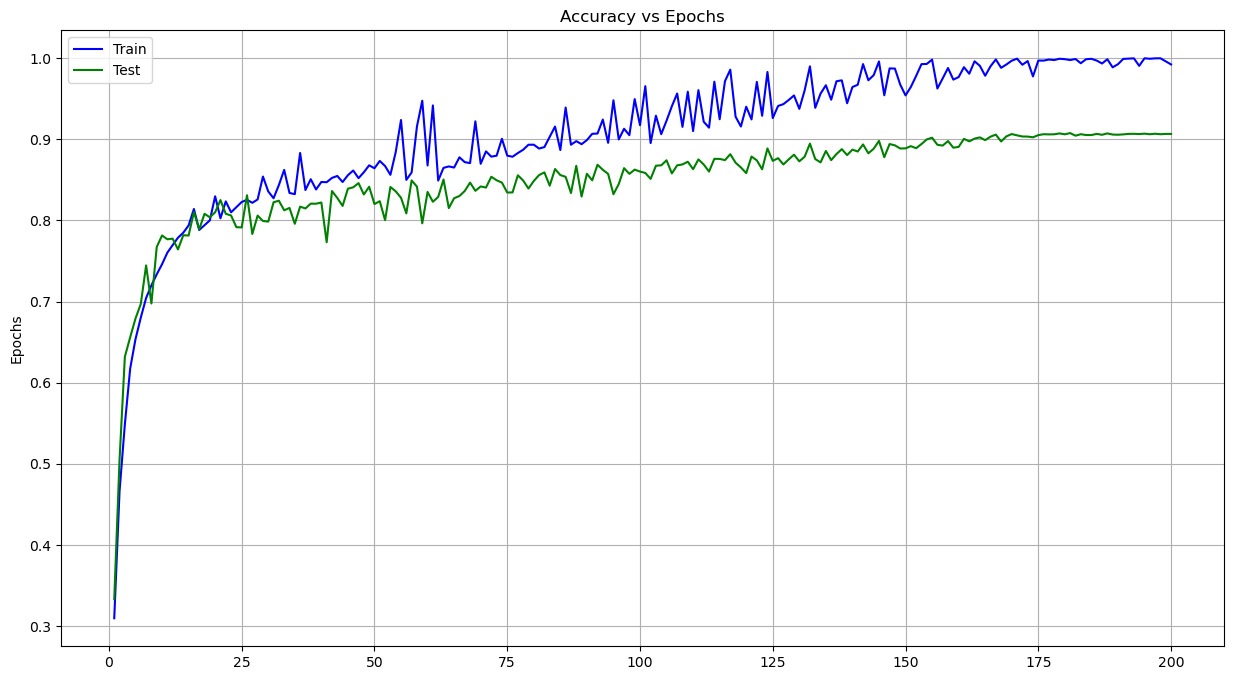

In [17]:
plt.figure(figsize=(15, 8))
plt.plot(epochs, train_accu,c='blue', linestyle = '-', label = 'Train')
plt.plot(epochs, test_accu ,c='green', linestyle = '-', label = 'Test')
plt.ylabel("Accuracy")
plt.ylabel('Epochs')
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

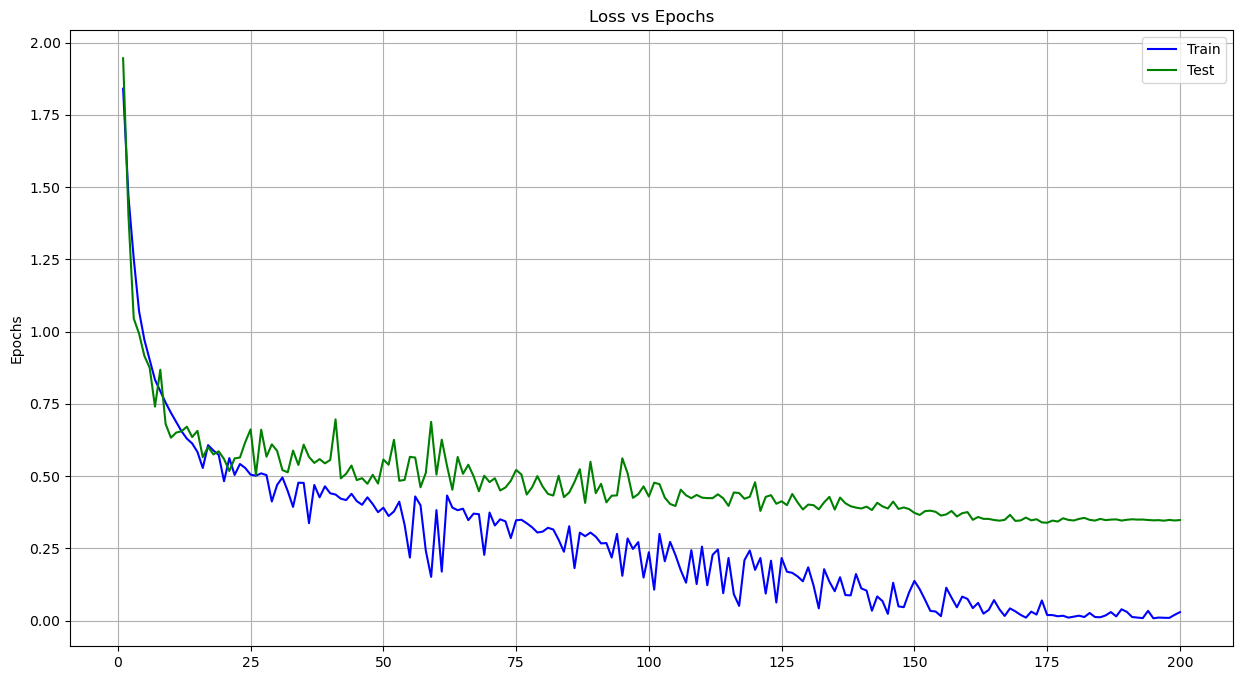

In [18]:
plt.figure(figsize=(15, 8))
plt.plot(epochs, train_loss,c='blue', linestyle = '-', label = 'Train')
plt.plot(epochs, test_loss ,c='green', linestyle = '-', label = 'Test')
plt.ylabel("Loss")
plt.ylabel('Epochs')
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()